In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
X_train = pd.read_csv('data/input/non_standardized_X_train.csv', index_col=0)
y_train = pd.read_csv('data/input/y_train.csv', index_col=0)

In [3]:
X_test = pd.read_csv('data/input/non_standardized_X_test.csv', index_col=0)

In [4]:
np.random.seed(42)

### 10-fold Cross-Validation

In [5]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [6]:
def kfold_mse(X, y, model, k=10):
    kf = KFold(n_splits=k)
    mses = []
    for i, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_train, y_train['sales']) # Avoid deprecation warning
        y_pred = model.predict(X_val)
        mses.append(mean_squared_error(y_pred, y_val['sales']))
    return mses

Since scikit-learn's implementation of random forest has many tunable hyperparameters, we shall concern only `ccp_alpha` in this project. `n_estimators`, `max_features`, `min_samples_split` are fixed to 1000, 'sqrt' and 0.01. Actually, using more estimators is better as random forest does not overfit. 1000 is a good number to stay within computational time limits.

In [7]:
ccp_alphas = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 1.0]

In [8]:
from sklearn.ensemble import RandomForestRegressor

In [9]:
best_mses = []
best_avg_score = 1e9
best_ccp_alpha = None
for ccp_alpha in ccp_alphas:
    model = RandomForestRegressor(min_samples_split=0.01, ccp_alpha=ccp_alpha, n_estimators=1000, max_features='sqrt', random_state=42)
    mses = kfold_mse(X_train, y_train, model)
    if np.mean(mses) < best_avg_score:
        best_avg_score = np.mean(mses)
        best_ccp_alpha = ccp_alpha
        best_mses = mses
    print(f'ccp_alpha: {ccp_alpha}, avg_mse: {np.mean(mses)}')

ccp_alpha: 0.005, avg_mse: 365.2377701530189
ccp_alpha: 0.01, avg_mse: 365.23064673745625
ccp_alpha: 0.02, avg_mse: 365.2130566359327
ccp_alpha: 0.03, avg_mse: 365.2064925628568
ccp_alpha: 0.04, avg_mse: 365.2070808716698
ccp_alpha: 0.05, avg_mse: 365.2070711524956
ccp_alpha: 0.1, avg_mse: 365.2751536774555
ccp_alpha: 0.5, avg_mse: 367.69801357340805
ccp_alpha: 1.0, avg_mse: 372.1876908128344


### In-sample analysis

In [10]:
cv_df = pd.DataFrame(best_mses, columns=['Cross-Validation MSE'])
cv_df

,Cross-Validation MSE
0,303.540485
1,152.051775
2,422.092836
3,273.900828
4,342.324230
5,154.464438
6,571.656051
7,342.044437
8,963.646950
9,126.342896


In [11]:
cv_df.to_csv('data/output/cv/rf.csv')

### Model fitting

After finding best parameters (not applicable to LR but useful for other models), we fit the model on the entire training set and predict on the test set. Also, we collect residuals to prepare for inventory decision making.

In [12]:
rf = RandomForestRegressor(min_samples_split=0.01, ccp_alpha=best_ccp_alpha, n_estimators=1000, max_features='sqrt', random_state=42)
rf.fit(X_train, y_train['sales']) # Avoid deprecation warning
residuals = y_train['sales'] - rf.predict(X_train)

In [13]:
output_df = X_test.copy()

In [14]:
output_df['sales'] = rf.predict(X_test)

### Inventory decision
As sales data come from a natural process, we shall not assume it is distributed in any particular model. Hence, we shall use an empirical distribution to make our inventory decision. 

In [16]:
residuals.describe()

count    2211.000000
mean       -0.057675
std        14.607823
min       -27.024018
25%        -4.518163
50%        -2.202998
75%         0.668865
max       311.844577
Name: sales, dtype: float64

For visualization of Empirical CDF, we use the `statsmodels` package:

In [17]:
from statsmodels.distributions.empirical_distribution import ECDF

In [18]:
ecdf = ECDF(residuals)

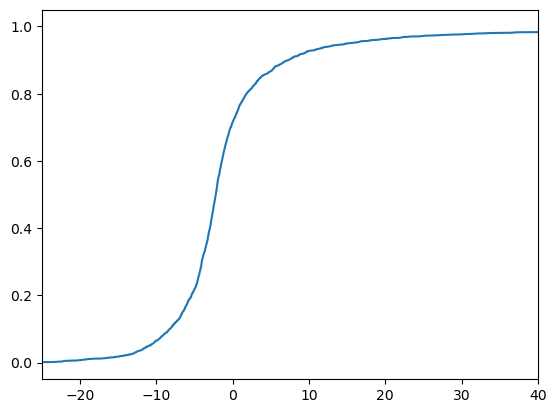

In [21]:
plt.plot(ecdf.x, ecdf.y)
plt.xlim(-25, 40)
plt.show()

Sparsity is not a concern since we have a large sample size. Therefore, we can use interpolation to obtain ppf. To get the empirical ppf, we can use scipy's `interp1d` to get the inverse function:

In [22]:
from scipy.interpolate import interp1d

In [23]:
eppf = interp1d(ecdf.y, ecdf.x)

Calculate the critical fractile

In [24]:
price = 20
cost = 12
salvage = 8
over = cost - salvage
under = price - cost
critical_fractile = under / (over + under)
critical_fractile

0.6666666666666666

We offset our predictions for the test datasets by the $eppf(critical\_fractile)$ to get the optimal inventory level.

In [25]:
output_df['inventory'] = eppf(critical_fractile) + output_df['sales']

In [26]:
output_df[['sales', 'inventory']].head()

,sales,inventory
0,33.784907,33.068487
1,58.733685,58.017265
2,23.273405,22.556984
3,26.107254,25.390833
4,10.365062,9.648642


In [27]:
output_df.to_csv('data/output/predictions/rf.csv')